# 笔记：
1. pd.factorize() 参考链接 https://blog.csdn.net/liuweiyuxiang/article/details/78222818  
2. text.translate(string.punctuation+('1234567890')) --- str.translate()

随着全球手机使用量的增长，一种创造垃圾电子邮件的新途径已经为声名狼藉的营销市场开放了。这些广告商利用短信服务（SMS）文本信息，以潜在消费者为目标，给他们发送不需要的广告，即垃圾短信。这种类型的垃圾短信特别麻烦，它与垃圾邮件不同，因为许多手机用户需要为收到的每一条短息付费。研究一种可以过滤垃圾短信的分类算法，将会给移动电话供应商提供一种很有用的工具。

由于朴素贝叶斯（Naive Bayes）已经成功应用于垃圾邮件的过滤，所以它很可能也可以应用于垃圾短信的过滤，然而，相对于垃圾邮件来说，垃圾短信的自动过滤有着额外的挑战。由于短信通常限制为160个字符，所以可以用来确定一条消息是否是垃圾信息的文本量减少了，这种限制与小的不方便手机键盘一起，导致很多人采用短信术语简写的形式，这进一步模糊了合法消息和垃圾消息的界限。让我们看一看一个简单的朴素贝叶斯分类器如何处理好这些问题带来的挑战。

## 1 收集数据

为了扩展朴素贝叶斯分类器，我们将使用从网站收集的垃圾短信改编的数据。

 要了解更多关于垃圾短信的数据，可以参考作者发表的文章：On the Validity of a New SMS Spam Collection by J.M. Gomez Hidalgo, T.A. Almeida and A. 
Yamakami in Proceeding of the 11th IEEE International Conference on Machine Learning and Applications(2012)。

### 数据集介绍

#### 该数据集包含短信的文本信息，而且带有表明该短信是否为垃圾短信的标签。垃圾短信标记为spam，而非垃圾短信标记为ham。在下面的一些例子中有一些关于垃圾短信和非垃圾短信的例子。
#### 下面是一些非垃圾短信（ham）的例子：

Better. Made up for Friday and stuffed myself like a pig yesterday. Now I feel bleh. But at least its not writhing pain kind of bleh.

lf he started searching he will get job in few days. He have great potential and talent.

I got another job! The one at the hospital doing data analysis or something, starts on monday! Not sure when my thesis will got finished.

#### 下面是一些垃圾短信（spam）的例子：

Congratulations ur awarded 500 of CD vouchers or 125 gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066

December only! Had your mobile 11mths+? You are entitled to updata to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on  08002986906 
Valentines Day Special! Win over $ 1000 in our quiz and take your partner on the trip of a lifetime! Seng GO to 83600 now. 150/pmsg rcvd.

#### 结论

一方面，一个显著特点是3条垃圾短信中有2条短信使用了单词free，但该单词没有出现在任何一条非垃圾短信中。另一方面，与垃圾短信相比，有2条非垃圾短信引用了一周中的具体某一天，而垃圾短信中没有一条引用。

我们的朴素贝叶斯分类器将利用词频中这种模式的优势来确定短信消息是更像垃圾短信还是非垃圾短信。尽管可以想象单词“free”可以出现在非垃圾短信中，但是一条合法的短信很有可能会根据上写文提供额外的单词信息。例如，一条非垃圾短信可能会这样陈述“are you free on Sunday?”；而一条垃圾短信可能会使用这样的短语“free ringtones”。朴素贝叶斯分类器将根据短信中所有单词提供的证据计算垃圾短信和非垃圾短信的概率。

## 2 探索和准备数据

构建分类器的第一步涉及原始数据的处理与分析，文本数据的准备具有挑战性，因为将词和句子转化成计算机能够理解的形式是很必要的。我们将把数据转化成一种称为词袋（bag-of-words）的表示方法，这种表示方法忽略了单词出现的顺序，只是简单地提供一个变量用来表示单词是否会出现。

为了使数据可以在Python中方便地应用，这里所使用的数据已经对原始数据进行了修正。

我们首先使用 pandas 库中的read_csv()函数导入上述CSV数据

In [1]:
import pandas as pd
sms_raw = pd.read_csv("./data/sms_spam.csv", encoding = 'gbk')

In [2]:
sms_raw.describe()

,type,text
count,5567,5567
unique,2,5154
top,ham,"Sorry, I'll call later"
freq,4822,30


In [17]:
sms_raw.head()

,type,text
0,0,"go1until1jurong1point,1crazy..1available1only1..."
1,0,ok1lar...1joking1wif1u1oni...
2,1,free1entry1in121a1wkly1comp1to1win1fa1cup1fina...
3,0,u1dun1say1so1early1hor...1u1c1already1then1say...
4,0,"nah1i1don8t1think1he1goes1to1usf,1he1lives1aro..."


使用 DataFrame 中的 descirbe() 方法，可以看到sms_raw数据文件包含了5567条短信，每条短信都有两个变量：type和text。其中SMS的变量type编码为ham或者spam，而变量text则存储整个SMS短信文本。

In [4]:
sms_raw.dtypes

type    object
text    object
dtype: object

当前的特征type是一个字符串向量。由于它是一个分类变量，所以将其转换成一个因子变量将有利于后续的数据处理，其中 1 表示垃圾短信，0 表示非垃圾短信，如下面的代码所示：

In [5]:
#pd.Series(sms_raw['type'].factorize())

In [6]:
sms_raw['type'] = pd.Series(sms_raw['type'].factorize()).iloc[0]

In [7]:
sms_raw.groupby('type').count()

,text
type,
0,4822
1,745


In [8]:
import seaborn as sns



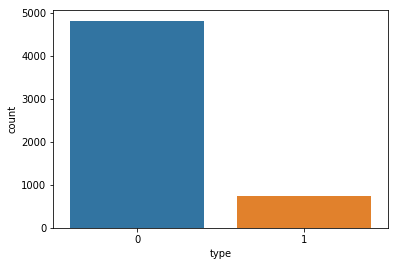

In [10]:
sns.countplot('type', data = sms_raw)

观察变量 type 的分布情况，可以看到数据集中有745条（大约13%）短信被标记为spam，其余的短信被标记为ham。

现在，先不研究变量text。因为处理原始短信需要使用一套新的专门用于处理文本数据的功能强大的工具。

## 3 数据准备——处理和分析文本数据

短信就是由词、空格、数字和标点符号组成的文本字符串。处理这种类型的复杂数据需要大量的思考和工作，一方面需要考虑如何去除数字和标点符号，如何处理没有意义的单词，如and、but和or等，以及如何将句子分解成单个的单词。幸运的是，Python 的 sklearn 库中已经包含了这些功能。

可以通过命令 pip install scikit-learn 来安装 scikit-learn 包，并应用命令 import sklearn 进行加载。

处理文本数据的第一步涉及创建一个语料库，即一个文本文件的集合。在我们的例子中，一个文本文件就是指一条短信，我们通过下面的命令建立一个包含训练数据中短信的语料库。

In [12]:
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn import metrics

### 数据预处理

语料库现在包含5568条短信的原始文本内容。在将文本内容分解成单词之前，我们需要进行一些清理步骤以去除标点符号和可能会影响结果的其他字符。例如，我们将把单词hello!、HELLO和Hello等都作为单词hello的样本。

首先我们利用 map 方法去除文本内容中的标点符号和数字，并将文本中所有的字符串都转换成小写形式：

In [14]:
def tolower(text):
    return text.lower()

def removePunctuation(text):
    return text.translate(string.punctuation+('1234567890'))

sms_raw['text'] = sms_raw['text'].map(removePunctuation).map(tolower)

In [18]:
#sms_raw['text']

在分析文本数据时，一个常见的做法就是去除填充词，比如to、and、but和or，这些词称为停用词（stop word）。我们将使用 sklearn 包中的 CountVectorizer 方法来去除停止词并计算文本的词频分布情况：

In [19]:
count_vect = CountVectorizer(stop_words="english",decode_error='ignore')
sms_counts = count_vect.fit_transform(sms_raw['text'])
sms_counts.shape

(5567, 12182)

由于原始的词频矩阵中维度过高，所以我们考虑利用 TF-IDF 进行特征提取，设定最小词频数为5，共提取出 198 个变量

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words="english",decode_error='ignore',min_df=5)
sms_tfidf = tfidf_vect.fit_transform(sms_raw['text'])
sms_tfidf.shape

(5567, 198)

### 建立训练数据集和测试数据集

由于已经为分析准备好了数据，所以现在我们需要将数据分成训练数据集和测试数据集，从而可以把垃圾短信分类器应用到之前没有学习过的数据上，并据此对分类器的性能进行评估。我们将数据分成两部分：75%的训练数据和25%的测试数据。因为短信的排序是随机的，所以我们可以简单地取前4176条短信用于训练，剩下的1391条用于测试。

In [21]:
sms_trainx = sms_tfidf[0:4175,]
sms_trainy = sms_raw['type'][0:4175]
sms_testx = sms_tfidf[4176:5567,]
sms_testy = sms_raw['type'][4176:5567]

### 可视化文本数据——词云

词云是一种可视化地描绘单词出现在文本数据中频率的方式。词云是由随机分布在词云图中的单词构成的，经常出现在文本中的单词会以较大的字体呈现，而不太常见的单词将会以较小的字体呈现。最近，这种类型的图已经变得越来越流行，因为它提供了一种观察社交媒体网站上热门话题的方式。

wordcloud包提供了一个简单的函数来创建这种类型的图形，我们将应用这个函数使短信中单词类型可视化。比较垃圾短信和非垃圾短信的词云将有助于我们了解朴素贝叶斯短信过滤器是否有可能成功。

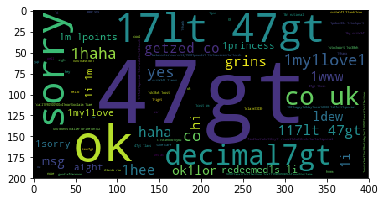

In [24]:
wc = WordCloud()
wc.generate(''.join(sms_raw['text']))
plt.imshow(wc)
plt.show()

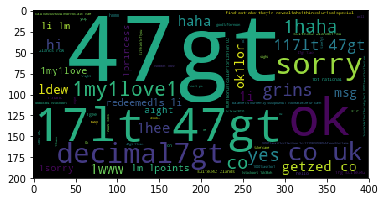

In [23]:
wc = WordCloud()
wc.generate(''.join(sms_raw['text']))
plt.imshow(wc)
plt.show()

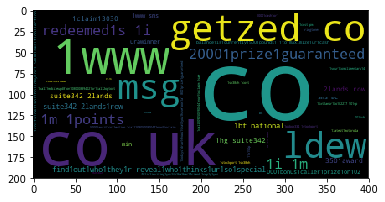

In [26]:
wc.generate(''.join(sms_raw['text'][sms_raw['type']==1]))
plt.imshow(wc)
plt.show()

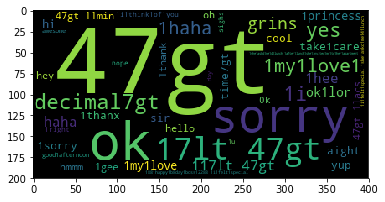

In [27]:
wc.generate(''.join(sms_raw['text'][sms_raw['type']==0]))
plt.imshow(wc)
plt.show()

所得到的词云显示在上面的两幅图形中。一幅图代表的是垃圾短信，一幅图代表的是非垃圾短信

由于是随机化的处理，所以每一个词云看上去可能会略有不同可以通过多次运行wordcloud()函数来选择最令人满意的词云，从而达到演示的目的。

观察词云。垃圾短信包括urgent、free、mobile、call、claim和stop等词，而这些单词一次都没有出现在非垃圾短信中，相反非垃圾短信使用的单词有can、sorry、need和time等。这些明显的差异表明我们的朴素贝叶斯模型将会有一些强有力的关键词来对类别进行区分。

### 4. 基于数据训练模型

因为我们已经将原始短信转换成了可以用一个统计模型代表的形式，所以此时是应用朴素贝叶斯算法的时候了。该算法将根据单词的存在与否来统计一条给定的短信是否是垃圾短信的概率。

我们采用 sklearn 包中的朴素贝叶斯算法实现。

In [28]:
from sklearn.naive_bayes import MultinomialNB
sms_classifier = MultinomialNB().fit(sms_trainx,sms_trainy)

### 5 评估模型的性能

为了评估短信分类器，我们需要基于测试数据中未知的短信来检验分类器的预测值。回想一下，未知的短信特征存储在一个名为sms_testx的矩阵中，而分类标签spam和ham存储在sms_testy中。我们把已经训练过的分类器命名为sms_classifier，我们将用它来产生预测值，并将预测值与真实值相比较。

In [30]:
# 对测试集的样本进行预测
sms_test_pred = sms_classifier.predict(sms_testx)
metrics.confusion_matrix(sms_testy, sms_test_pred)

array([[1209,    0],
       [ 101,   81]], dtype=int64)

从表中可以看出，1209条非垃圾短信全部正确分类，而182条垃圾短信中有101条短信被错误地归为非垃圾短信。考虑到在这个案例中，我们几乎没有做什么工作，具有这种水平的表现是相当好的。另外，本案例的研究也说明了为什么说朴素贝叶斯算法是用于文本分类的一种标准算法，而且朴素贝叶斯方法可以直接拿来使用，执行的效果也是出奇地好。

另一方面，如果短信被错误地归为垃圾短信，可能会为过滤算法的部署带来显著的问题。如果过滤器导致某人错过一条重要的约会或者紧急情况的短信，那么他们会很快放弃这种产品，因此我们需要研究这些错误分类的短信，看看是哪里出了问题。

最后，我们观察下模型的分类指标，发现朴素贝叶斯模型的精度和召回率都达到 93%，说明我们所构建的模型能够很好地识别出垃圾短信。

In [31]:
print(metrics.classification_report(sms_testy,sms_test_pred))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96      1209
          1       1.00      0.45      0.62       182

avg / total       0.93      0.93      0.91      1391

